# EBNH: Left-hand side operator of the system for the Lagrangian forces

Objective: check if the operator `ENBH` (as implemented in PetIBM) is symmetric.

In [1]:
import itertools
import math
from matplotlib import pyplot
import numpy
from scipy.sparse import csr_matrix

import pyibm

In [2]:
%matplotlib inline

In [3]:
pyibm.__version__

'0.1'

## Create stretched Cartesian grids

In [4]:
# Set parameters of the computational grid.
xlim, ylim = (-15.0, 15.0), (-15.0, 15.0)  # domain limits
xbox, ybox = (-0.75, 0.75), (-0.75, 0.75)  # uniform region
dx, dy = 0.05, 0.05  # grid spacings in the uniform region

config_x = [dict(start=xlim[0], end=xbox[0],
                 width=dx, stretching=1.03, reverse=True),
            dict(start=xbox[0], end=xbox[1], width=dx),
            dict(start=xbox[1], end=xlim[1],
                 width=dx, stretching=1.01)]

config_y = [dict(start=ylim[0], end=ybox[0],
                 width=dy, stretching=1.04, reverse=True),
            dict(start=ybox[0], end=ybox[1], width=dy),
            dict(start=ybox[1], end=ylim[1],
                 width=dy, stretching=1.04)]

config = {'x': dict(start=xlim[0], segments=config_x),
          'y': dict(start=ylim[0], segments=config_y)}

# Create staggered grids.
grid = pyibm.GridBase(config=config)  # vertex grid
gridc = pyibm.GridCellCentered(grid=grid)  # cell-centered grid
gridx = pyibm.GridFaceX(grid=grid)  # x-face grid
gridy = pyibm.GridFaceY(grid=grid)  # y-face grid
print(gridc)
print(gridx)
print(gridy)

Grid(size=38078, shape=(158, 241), gridlines=[
Gridline(start=-15.0, end=15.0, size=241),
Gridline(start=-15.0, end=15.0, size=158)])
Grid(size=37920, shape=(158, 240), gridlines=[
Gridline(start=-15.0, end=15.0, size=240),
Gridline(start=-15.0, end=15.0, size=158)])
Grid(size=37837, shape=(157, 241), gridlines=[
Gridline(start=-15.0, end=15.0, size=241),
Gridline(start=-15.0, end=15.0, size=157)])


## Assemble operators

In [5]:
# Create the Laplacian operator.
LHat = pyibm.assemble_LHat(gridx, gridy)
pyibm.print_matrix_info(LHat, name='LHat')

Name:  LHat
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (75757, 75757)
Size:  377193
Symmetric:  False
Min/Max:  -1600.0000000000057 400.00000000000193


In [6]:
# Assemble the approximate inverse of the operator A (velocity system).
dt = 0.01  # time-step size
Re = 100.0  # Reynolds number
a_I = 0.5  # implicit coefficient from Crank-Nicolson scheme
N = 1  # order of the truncated Taylor series
BN = pyibm.assemble_BN(gridx, gridy, dt=dt,
                       alpha=a_I / Re, N=N, L=LHat)
pyibm.print_matrix_info(BN, name='BN')

Name:  BN
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (75757, 75757)
Size:  75757
Symmetric:  True
Min/Max:  0.01 0.01


## Create immersed boundary

In [7]:
def circle(radius=0.5, center=(0.0, 0.0), ds=0.1, phi=0.0):
    """Compute uniformly distributed coordinates on circle."""
    xc, yc = center
    N = math.ceil(2 * math.pi * radius / ds)
    theta = numpy.linspace(0.0, 2 * math.pi, num=N + 1)[:-1] + phi
    x = xc + radius * numpy.cos(theta)
    y = yc + radius * numpy.sin(theta)
    return x, y

In [8]:
# Create immersed boundary.
body = pyibm.Body(*circle(ds=dx), grid=gridc)
body

Body(ndim=2, size=63)

In [9]:
# Set the delta kernel to use and support size.
delta_kernel = pyibm.delta_roma_et_al_1999
delta_kernel_size = 2

# Create the transfer kernel (Euler -> Lagrange).
Op = pyibm.assemble_delta(body, gridc, gridx, gridy,
                          kernel=delta_kernel,
                          kernel_size=delta_kernel_size)
pyibm.print_matrix_info(Op, 'Delta kernel')

Name:  Delta kernel
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 75757)
Size:  1122
Min/Max:  5.423461406350576e-07 177.75685547777775


## Assemble left-hand side operator of the system for the Lagrangian forces

In [10]:
# Create the scaling diagonal matrix MHat.
MHat = pyibm.assemble_MHat(gridx, gridy)
pyibm.print_matrix_info(MHat, name='MHat')

Name:  MHat
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (75757, 75757)
Size:  75757
Symmetric:  True
Min/Max:  0.04999999999999993 0.585079379552818


In [11]:
# Create the scaling diagonal matrix R.
R = pyibm.assemble_R(gridx, gridy)
pyibm.print_matrix_info(R, name='R')

Name:  R
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (75757, 75757)
Size:  75757
Symmetric:  True
Min/Max:  0.04999999999999982 0.5965515242499322


In [12]:
# Create the interpolation operator (as implemented in PetIBM).
EHat = Op @ R @ MHat
pyibm.print_matrix_info(EHat, name='EHat')

Name:  EHat
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 75757)
Size:  1122
Min/Max:  1.355865351587645e-09 0.44439213869444516


In [13]:
# Create the speading operator (as implemented in PetIBM).
HHat = csr_matrix(Op.T)
pyibm.print_matrix_info(HHat, name='HHat')

Name:  HHat
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (75757, 126)
Size:  1122
Min/Max:  5.423461406350576e-07 177.75685547777775


In [14]:
# Create the LHS operator of the system for the Lagrangian forces.
EBNH = EHat @ BN @ HHat
pyibm.print_matrix_info(EBNH, name='EBNH')

Name:  EBNH
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 126)
Size:  708
Symmetric:  True
Min/Max:  1.552007559688825e-08 1.0000000000000093


(0.031449168547259605, 2.0261331975887398, 64.42565228851787)

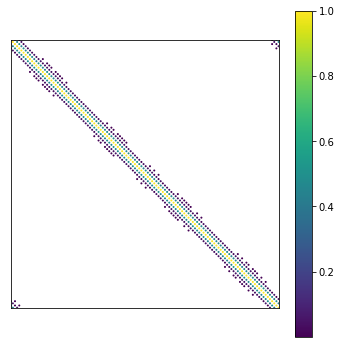

In [15]:
# Plot the non-zero structure of the operator.
pyibm.plot_matrix(EBNH, cmap='viridis');
pyibm.condition_number(EBNH)

## Analyze condition number of EBNH

In [16]:
N_all = [1, 2, 3]
xc_all = numpy.linspace(-dx, dx, num=11)
yc_all = numpy.linspace(-dx, dx, num=11)
ratios = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0]

data = {}
# Loop of order of truncated Taylor series.
for N in N_all:
    alpha = a_I / Re
    BN = pyibm.assemble_BN(gridx, gridy,
                           dt=dt, alpha=alpha, N=N, L=LHat)
    subdata = {}
    # Loop over value of grid-spacing ratio (Lagrange/Euler).
    for r in ratios:
        xc_vals, yc_vals = [], []
        cond_vals = []
        # Loop over location of center of boundary.
        for xc, yc in itertools.product(xc_all, yc_all):
            # Create immersed boundary.
            body = pyibm.Body(*circle(ds=r * dx, center=(xc, yc)),
                              grid=gridc)
            # Assemble delta operator.
            Op = pyibm.assemble_delta(body, gridc, gridx, gridy,
                                      kernel=delta_kernel,
                                      kernel_size=delta_kernel_size)
            # Assemble LHS operator of system for forces.
            EHat = Op @ R @ MHat
            HHat = csr_matrix(Op.T)
            EBNH = EHat @ BN @ HHat
            # Store data (body center and condition number)
            xc_vals.append(xc)
            yc_vals.append(yc)
            cond_vals.append(pyibm.condition_number(EBNH)[-1])
        # Record data for specific grid ratio.
        subdata[f'r={r}'] = {'xc': xc_vals, 'yc': yc_vals,
                             'cond': cond_vals}
    # Record data for specific truncation order.
    data[f'N={N}'] = subdata

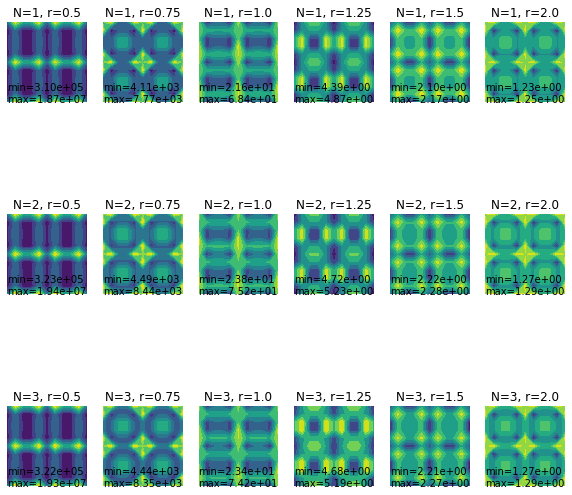

In [17]:
# Plot
fig, ax = pyplot.subplots(nrows=len(N_all), ncols=len(ratios),
                          figsize=(10.0, 10.0))
for i, N in enumerate(N_all):
    for j, r in enumerate(ratios):
        subdata = data[f'N={N}'][f'r={r}']
        cond = numpy.array(subdata['cond'])
        ax[i, j].set_title(f'N={N}, r={r}')
        ax[i, j].contourf(xc_all, yc_all,
                          cond.reshape((xc_all.size, yc_all.size)))
        ax[i, j].text(min(xc_all), min(yc_all),
                      'min={:.2e}\nmax={:.2e}'
                      .format(min(cond), max(cond)))
        ax[i, j].axis('scaled')
        ax[i, j].axis('off')